In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import copy
os.path.dirname(sys.executable)
# sys.path.append('/kuacc/users/ckoksal20/COMP547Project/SSuperGAN/')
sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [5]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.ssuper_model import SSuperModel
from networks.models import *
from utils.config_utils import read_config, read_config_from_path, Config
from utils.logging_utils import *
from utils.plot_utils import *

from configs.base_config import *
from functional.losses.elbo import elbo
# from functional.losses.gan_losses import *

In [19]:
config = read_config_from_path("../../configs/general_config.yaml")
print(config)
golden_age_config = read_config(Config.GOLDEN_AGE)
model_path = "ckpts/seq_vae_gan_model-checkpoint-epoch23.pth"
# model_path2 = "../ssuper_global_dcgan/weights/lstm_ssuper_global_dcgan_model-checkpoint-epoch169.pth"
model_path2 = "../ssuper_global_dcgan/ckpts/lstm_ssuper_global_dcgan_model-checkpoint-epoch23.pth"
# N_SAMPLES = 1280 # 50000

Config(backbone='efficientnet-b5', embed_dim=1024, latent_dim=512, use_lstm=True, seq_size=3, lstm_conv=False, lstm_hidden=1024, lstm_bidirectional=True, lstm_dropout=0, fc_hidden_dims=[], fc_dropout=0, num_lstm_layers=1, masked_first=True, img_size=64, panel_size=[300, 300], gen_channels=64, enc_channels=[64, 128, 256, 512], local_disc_channels=64, global_disc_channels=64, batch_size=20, train_epochs=200, lr=0.0002, weight_decay=2.5e-05, beta_1=0.5, beta_2=0.999, g_clip=100, local_disc_lr=0.0002, global_disc_lr=0.005, disc_mom=0.9, parallel=True)


In [20]:
net = SeqVAEGAN(
        backbone=config.backbone,
        embed_dim=config.embed_dim,
        latent_dim=config.latent_dim,
        img_size=config.img_size,
        use_lstm=config.use_lstm,
        gen_channels=config.gen_channels,
        enc_channels=config.enc_channels,
        local_disc_channels=config.local_disc_channels,
        global_disc_channels=config.global_disc_channels,
        seq_size=config.seq_size,
        lstm_conv=config.lstm_conv,
        lstm_bidirectional=config.lstm_bidirectional,
        lstm_hidden=config.lstm_hidden,
        lstm_dropout=config.lstm_dropout,
        fc_hidden_dims=config.fc_hidden_dims,
        fc_dropout=config.fc_dropout,
        num_lstm_layers=config.num_lstm_layers,
        masked_first=config.masked_first
    )

net2 = SSuperGlobalDCGAN(
    backbone=config.backbone,
    embed_dim=config.embed_dim,
    latent_dim=config.latent_dim,
    img_size=config.img_size,
    panel_size=config.panel_size,
    use_lstm=config.use_lstm,
    gen_channels=config.gen_channels,
    local_disc_channels=config.local_disc_channels,
    global_disc_channels=config.global_disc_channels,
    seq_size=config.seq_size,
    lstm_conv=config.lstm_conv,
    lstm_bidirectional=config.lstm_bidirectional,
    lstm_hidden=config.lstm_hidden,
    lstm_dropout=config.lstm_dropout,
    fc_hidden_dims=config.fc_hidden_dims,
    fc_dropout=config.fc_dropout,
    num_lstm_layers=config.num_lstm_layers,
    masked_first=config.masked_first)

if config.parallel:
    net = nn.DataParallel(net)
    net2 = nn.DataParallel(net2)

net.load_state_dict(torch.load(model_path)['model_state_dict'], strict=False)
net = net.cuda().eval()

net2.load_state_dict(torch.load(model_path2)['model_state_dict'], strict=False)
net2 = net2.cuda().eval()

dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              config.panel_size,
                              config.img_size, 
                              augment=False, 
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              return_mask_coordinates=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              shuffle=True,
                              limit_size=-1)

# dataset.data = [
#     [['593/29_6.jpg', '593/30_0.jpg', '593/30_1.jpg'], [[[29, 0, 532, 503], [183, 51, 281, 149]], [[7, 0, 543, 536], [90, 229, 206, 345]], 
#                                                         [[15, 0, 552, 537], [186, 192, 298, 304]]]], # animal
    
#     [['3918/34_0.jpg', '3918/34_1.jpg', '3918/34_2.jpg'], [[[31, 0, 570, 539], [117, 278, 239, 400]], [[0, 14, 506, 520], [155, 181, 195, 221]],
#                                                            [[18, 0, 514, 496], [121, 274, 229, 382]]]], # woman
    
#     [['211/20_0.jpg', '211/20_1.jpg', '211/20_2.jpg'], [[[612, 0, 1165, 553], [1041, 188, 1105, 252]], [[20, 0, 589, 569], [386, 189, 462, 265]],
#                                                         [[39, 0, 595, 556], [95, 175, 289, 369]]]], # bad man
    
#     [['915/30_1.jpg', '915/30_2.jpg', '915/30_3.jpg'], [[[0, 7, 419, 426], [127, 205, 255, 333]], [[0, 59, 356, 415], [160, 258, 282, 380]],
#                                                         [[0, 82, 264, 346], [89, 228, 193, 332]]]], # good man

#     [['3513/21_5.jpg', '3513/21_6.jpg', '3513/22_0.jpg'], [[[59, 0, 611, 552], [199, 180, 369, 350]], [[0, 17, 533, 550], [90, 206, 164, 280]],
#                                                            [[0, 69, 395, 464], [73, 230, 185, 342]]]], # good man

#     [['2464/73_4.jpg', '2464/73_5.jpg', '2464/73_6.jpg'], [[[131, 0, 743, 612], [225, 206, 361, 342]], [[168, 0, 890, 722], [602, 316, 658, 372]],
#                                                            [[73, 0, 740, 667], [185, 266, 331, 412]]]], # mask problem
# ]


data_loader = DataLoader(dataset, batch_size=1)

Loaded pretrained weights for efficientnet-b5
Loaded pretrained weights for efficientnet-b5


In [21]:
dl_iter = iter(data_loader)

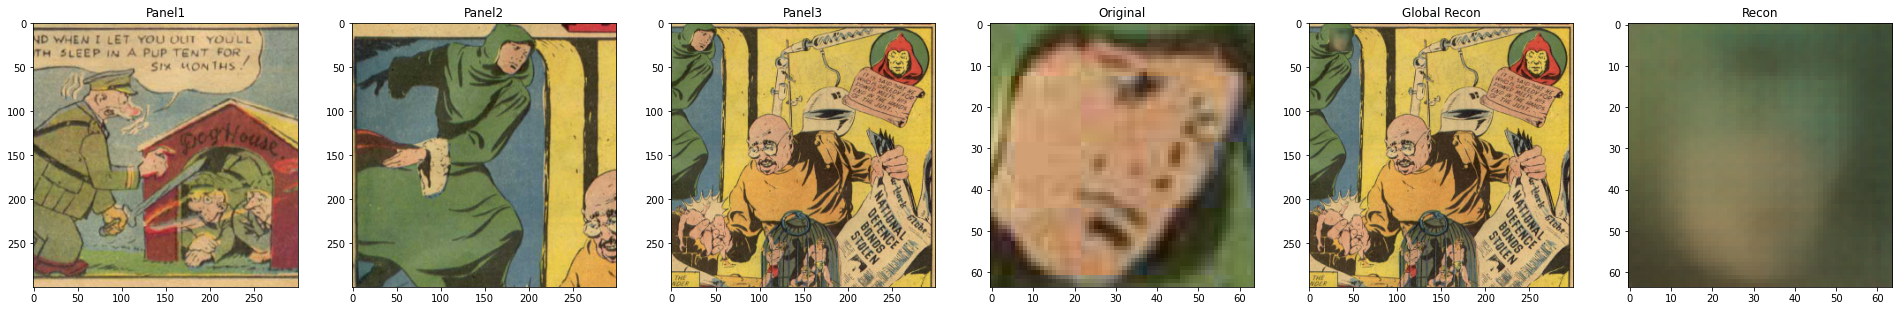

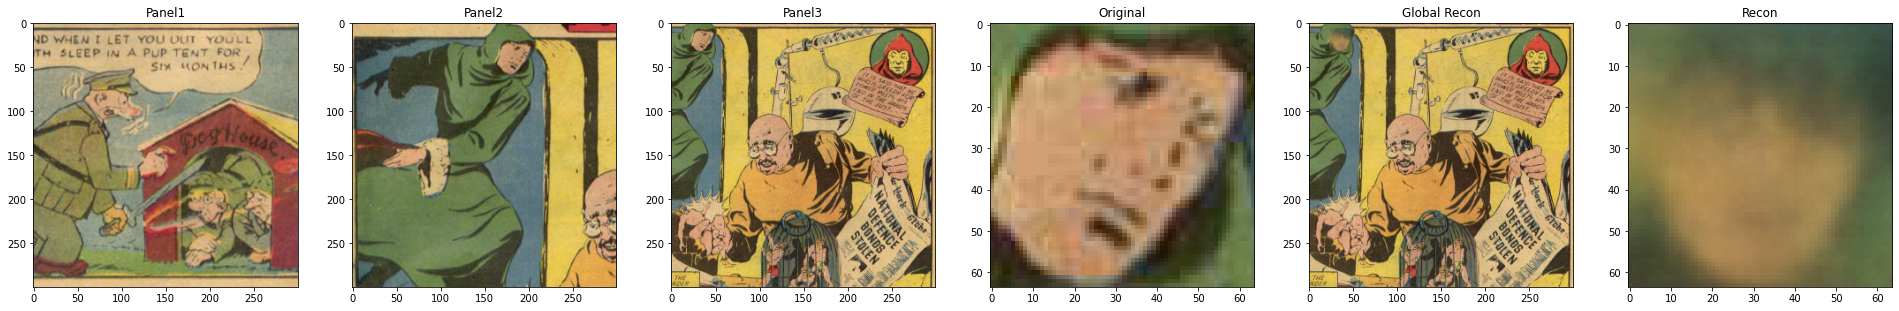

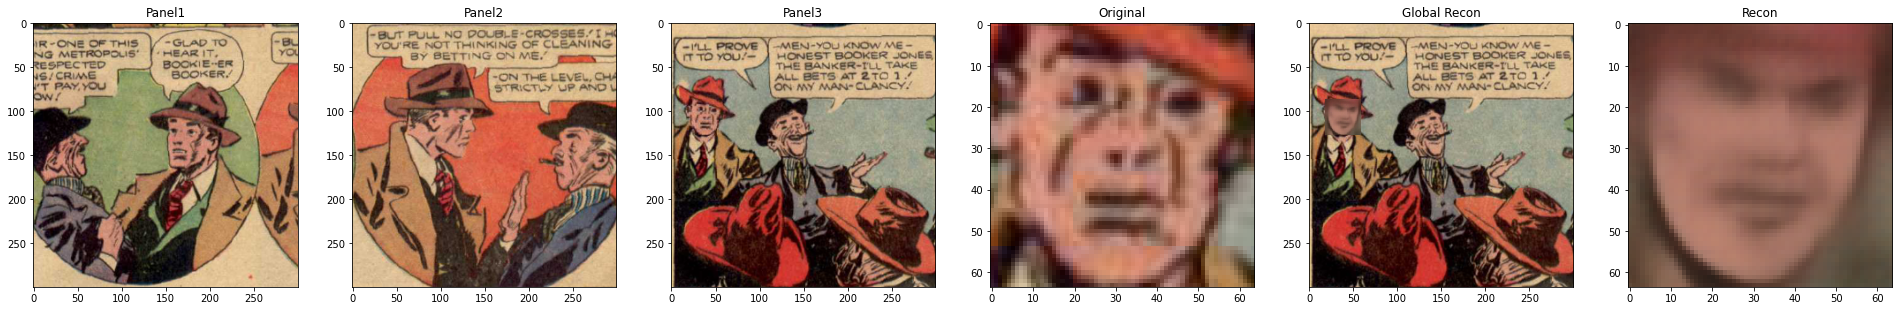

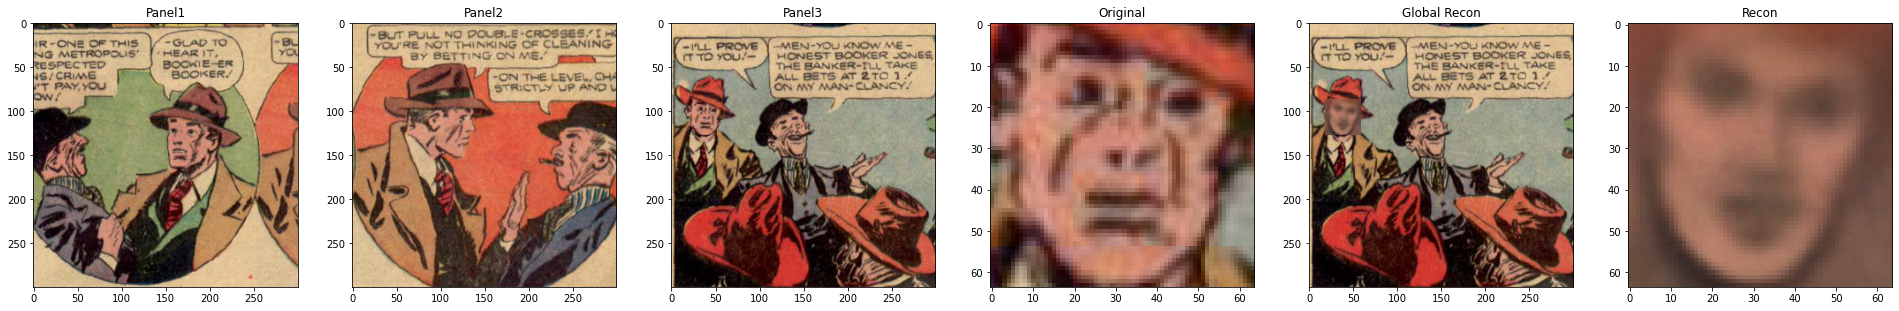

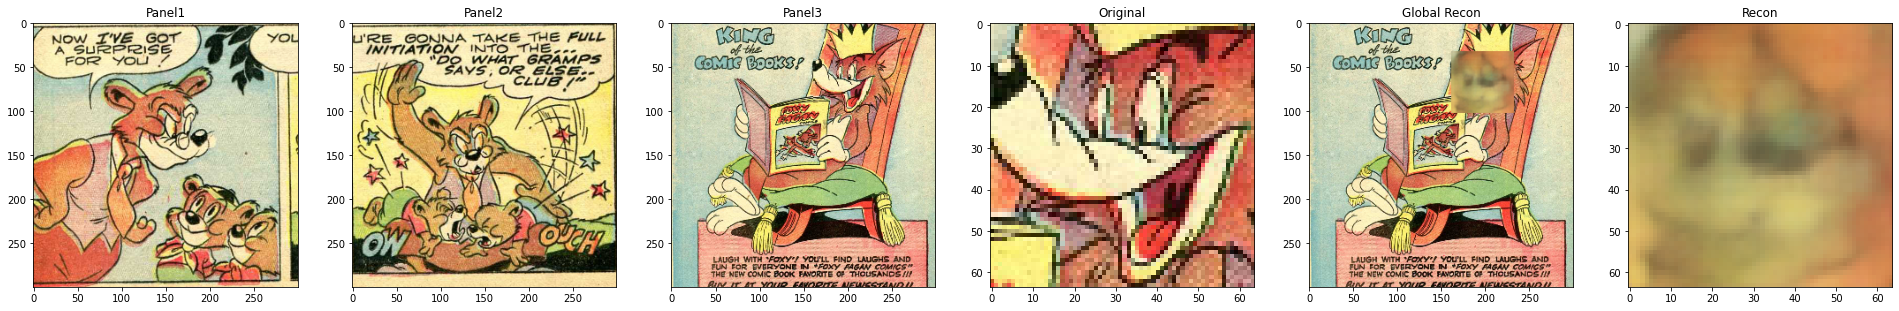

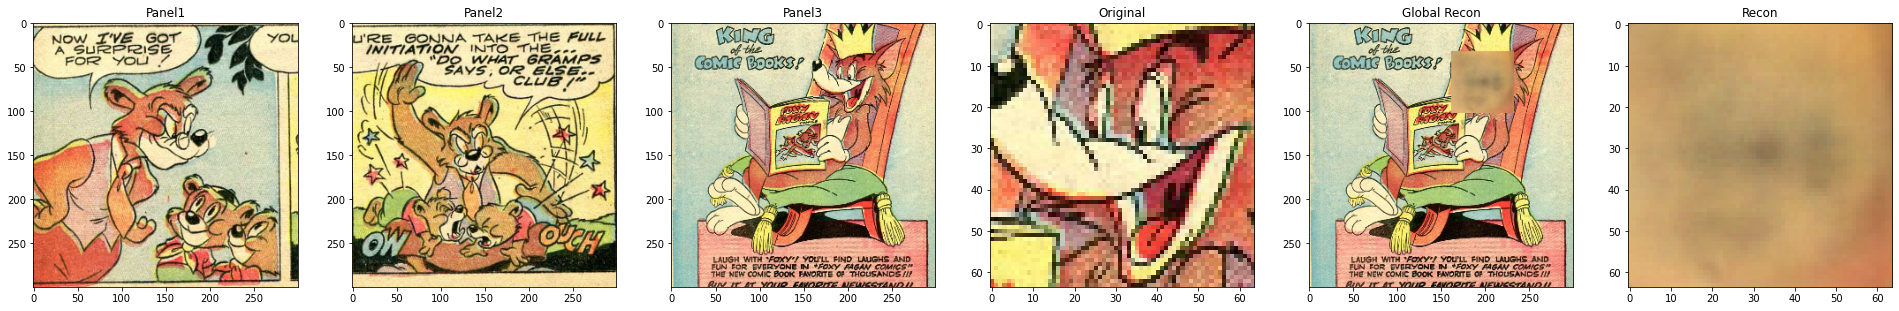

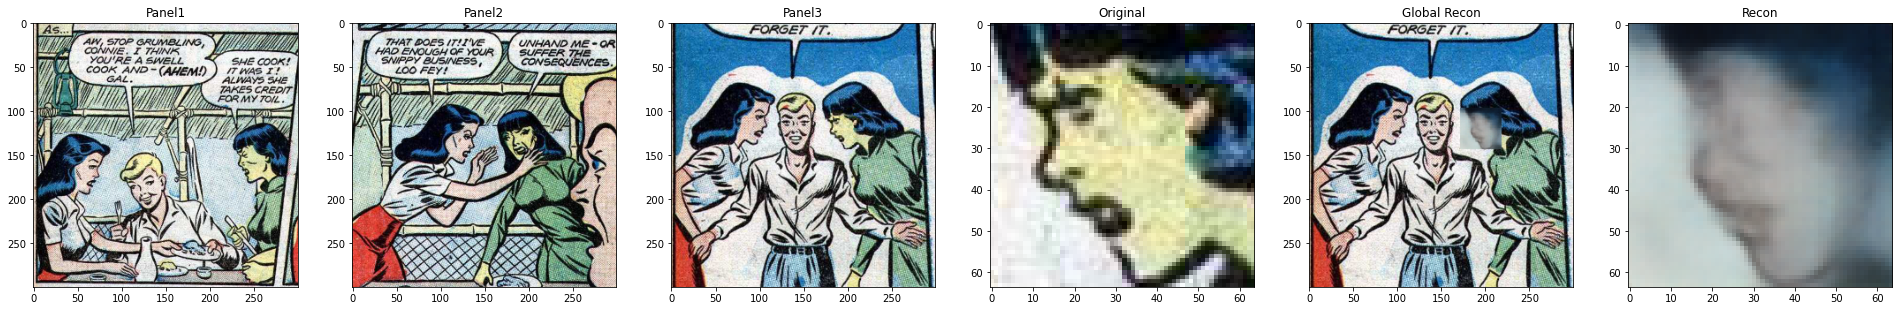

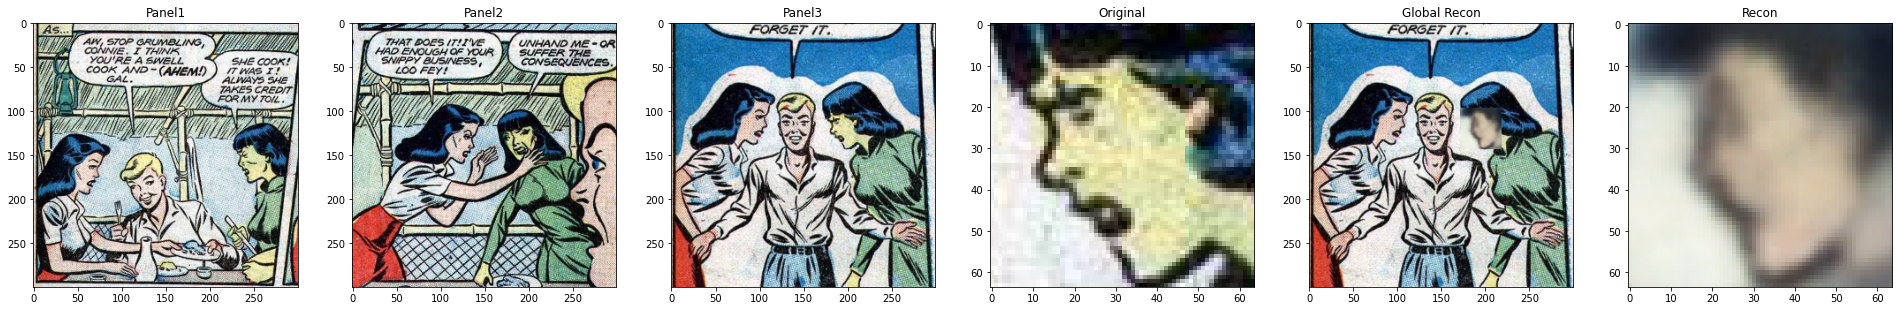

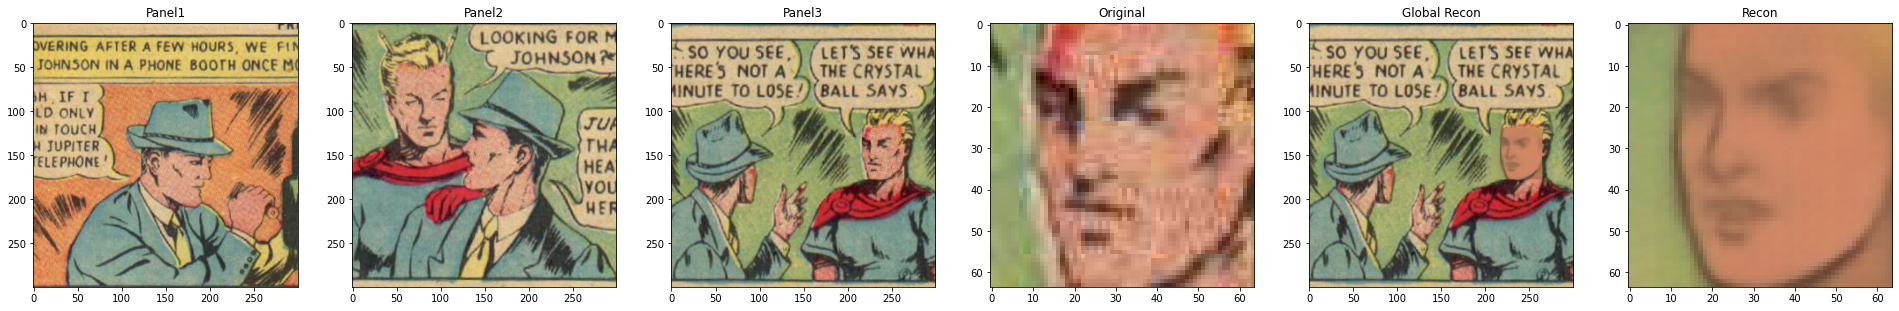

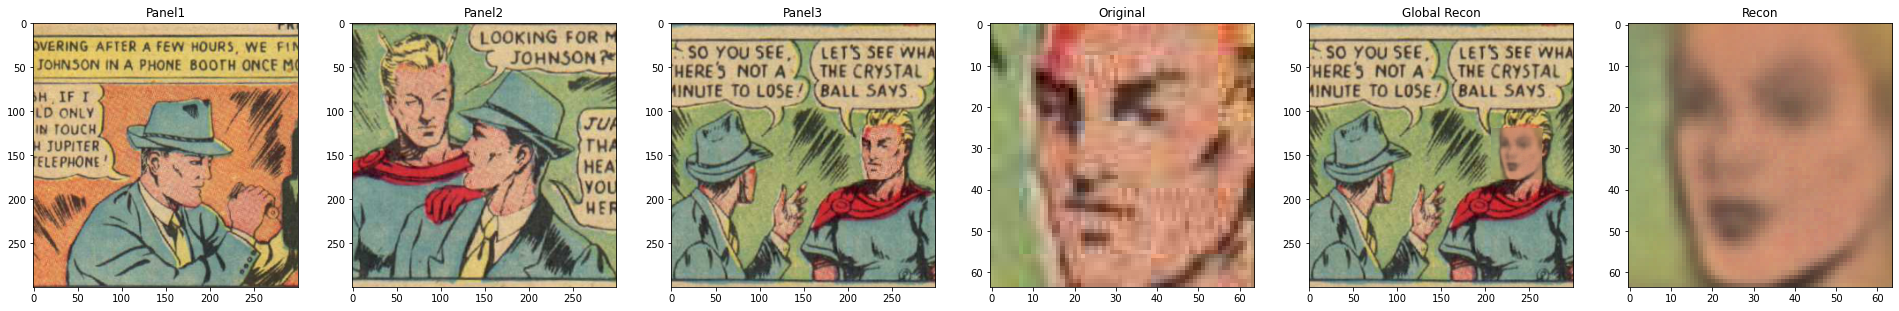

In [22]:
ctr, limit = 0, 5
for x, y, mask, coord in dl_iter:

    with torch.no_grad():
        # mu_z, _ = net(y.cuda(), f="encode")
        mu_z, _ = net(x.cuda(), f="seq_encode")
        mu_z = mu_z.unsqueeze(-1).unsqueeze(-1)
        y_recon = net(mu_z, f="generate")
        recon_global, gt_global = net.module.create_global_images(copy.deepcopy(x), y, y_recon, coord)
        plot_panels_and_faces(torch.cat([x[:,:2,:,:,:], gt_global.cpu().unsqueeze(1)], dim=1), y, y_recon, recon_global)
        
        mu_z, _ = net2(x.cuda(), f="seq_encode")
        mu_z = mu_z.unsqueeze(-1).unsqueeze(-1)
        y_recon = net2(mu_z, f="generate")
        recon_global, gt_global = net.module.create_global_images(copy.deepcopy(x), y, y_recon, coord)
        plot_panels_and_faces(torch.cat([x[:,:2,:,:,:], gt_global.cpu().unsqueeze(1)], dim=1), y, y_recon, recon_global)
        
#     if config.use_lstm and not config.lstm_conv:
#         net.module.seq_encoder.lstm.train()
        
#     draw_saliency(net, x, y)
        
#     if config.use_lstm and not config.lstm_conv:
#         net.module.seq_encoder.lstm.eval()
        
#     if config.use_lstm and not config.lstm_conv:
#         net2.module.seq_encoder.lstm.train()
        
#     draw_saliency(net2, x, y)
        
#     if config.use_lstm and not config.lstm_conv:
#         net2.module.seq_encoder.lstm.eval()
    
    ctr += 1
    if ctr == limit:
        break

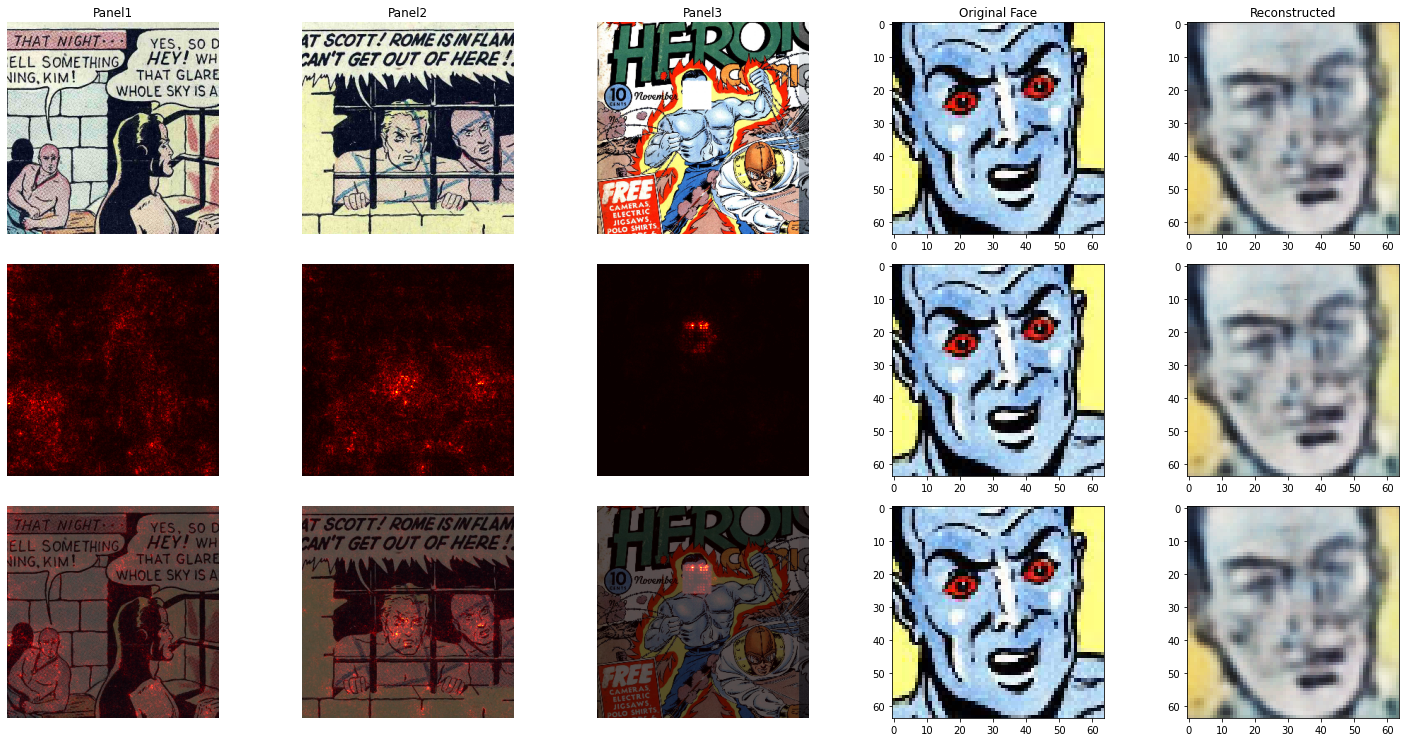

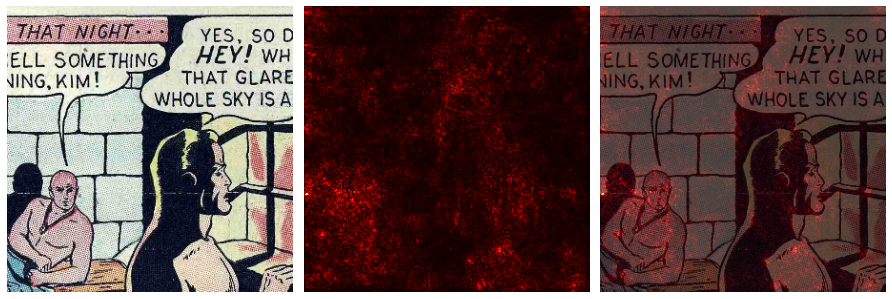

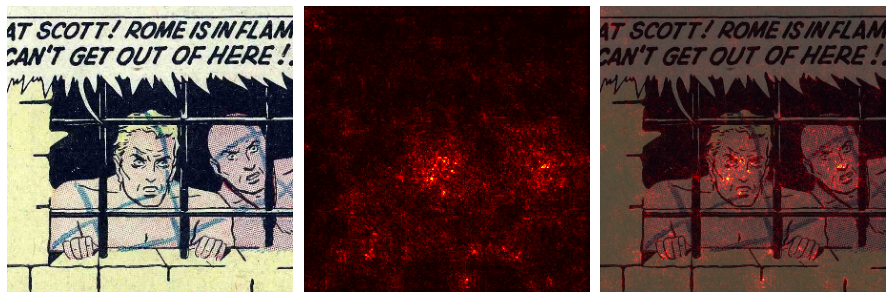

In [17]:
if config.use_lstm and not config.lstm_conv:
    net.module.seq_encoder.lstm.train()

x, y, mask, coord = next(dl_iter)
draw_saliency(net, x, y)

if config.use_lstm and not config.lstm_conv:
    net.module.seq_encoder.lstm.eval()

backbone = net.seq_encoder.embedder if not config.parallel else net.module.seq_encoder.embedder
draw_backbone_saliency(backbone, x, 0)
draw_backbone_saliency(backbone, x, 1)